In [449]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import numpy as np

In [450]:
molecules = pd.read_csv('../datas/molecules.csv', names=['id', 'none', 'pubchem_id', 'common_name', 'flavor_profile'], header=0)
flavor_db = pd.read_csv('../datas/flavordb.csv', names=['id', 'entry_id', 'alias', 'synonyms', 'scientific_name', 'category', 'molecules'], header=0)
flavor_db.drop(['id'], axis=1, inplace=True)

In [451]:
# Make all list of all flavors
all_flavors = molecules['flavor_profile'].apply(lambda x: x.replace("'", "").strip('{}').split(', ')).tolist()
unique_flavors = set([flavor for flavors in all_flavors for flavor in flavors])
print(f"{len(unique_flavors)}種類")
print(unique_flavors)

599種類
{'', 'cheesy', 'catty', 'balsamic', 'solvent', 'acetophenone', 'coumarinic', 'very mild', 'clary', 'amber', 'furfural', 'eugenol', 'meaty', 'low', 'beany', 'smoked', 'diphenyl oxide', 'cotton candy', 'flat', 'roasted nuts', 'beefy', 'wasabi', 'angelica', 'cassie', 'toluene', 'sulfur', 'malty', 'bay oil', 'caramel', 'yeast', 'coconut', 'lemon peel', 'repulsive', 'cinnamyl', 'pear', 'clover', 'acetoin', 'guaiacol', 'sassafrass', 'meat broth', 'sweaty', 'thymol', 'cool', 'honeydew', 'penetrating', 'pistachio', 'carrot', 'raspberry', 'alcohol', 'hyacinth', 'blackcurrant', 'extremely sweet', 'peanut butter', 'soft', 'amine', 'honeysuckle', 'petal', 'magnolia', 'plant', 'ham', 'new mown hay', 'blueberry', 'sappy', 'beet', 'butterscotch', 'chicken', 'apple peel', 'filbert', 'turpentine', 'muguet', 'roquefort cheese', 'almond shell', 'aniseed', 'fish', 'musk', 'unripe banana', 'vinous', 'cinnamic', 'shrimp', 'nutty', 'truffle', 'juicy', 'cyclamen', 'neroli', 'peony', 'nut skin', 'citric'

In [452]:
molecules.head(3)

,id,none,pubchem_id,common_name,flavor_profile
0,0,0.0,4,1-Aminopropan-2-ol,{'fishy'}
1,1,1.0,49,3-Methyl-2-oxobutanoic acid,{'fruity'}
2,2,2.0,58,2-oxobutanoic acid,"{'sweet', 'creamy', 'caramel', 'lactonic', 'br..."


In [453]:
# Make all list of all categories 
unique_categories = set([cate for cate in flavor_db['category']])
print(f"{len(unique_categories)}種類")
print(unique_categories)

34種類
{'fungus', 'vegetable', 'seed', 'maize', 'cereal', 'bakery', 'nut', 'additive', 'plant derivative', 'fruit', 'essential oil', 'gourd', 'cabbage', 'vegetable stem', 'dairy', 'fruit essence', 'legume', 'spice', 'flower', 'plant', 'herb', 'vegetable root', 'dish', 'vegetable tuber', 'beverage', 'beverage alcoholic', 'vegetable fruit', 'berry', 'meat', 'seafood', 'fish', 'fruit-berry', 'fruit citrus', 'beverage caffeinated'}


In [454]:
flavor_db.head(3)

,entry_id,alias,synonyms,scientific_name,category,molecules
0,1,bakery products,{'bakery products'},poacceae,bakery,"{27457, 7976, 31252, 26808, 22201, 26331}"
1,2,bread,{'bread'},poacceae,bakery,"{1031, 1032, 644104, 527, 8723, 31260, 15394, ..."
2,3,rye bread,{'rye bread'},rye,bakery,"{644104, 7824, 643731, 8468, 1049, 5372954, 80..."


In [455]:
# Create a matrix of ingredients and molecules
matrix_df = pd.DataFrame(index=flavor_db.index)

# 各行の pubchem_id を保存するリスト
columns_to_add = {}

for index, row in flavor_db.iterrows():
    pubchem_ids = row['molecules'].replace("{", "").replace("}", "").split(", ")
    for pubchem_id in pubchem_ids:
        if pubchem_id not in columns_to_add:
            columns_to_add[pubchem_id] = [0] * len(flavor_db)
        columns_to_add[pubchem_id][index] = 1

# 収集したデータを DataFrame に変換して concat で結合
new_columns_df = pd.DataFrame(columns_to_add)
matrix_df = pd.concat([matrix_df, new_columns_df], axis=1)

matrix_df.fillna(0, inplace=True)  # 空欄を0で埋める
matrix_df = matrix_df.transpose()
matrix_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,925,926,927,928,929,930,931,932,933,934
27457,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7976,1,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
31252,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [456]:
# 共起関係を計算
co_occurrence = matrix_df.T.dot(matrix_df)
# 統計情報を表示
describe = co_occurrence.describe().transpose().describe()
display_threshold = describe['75%']['mean']
# トマト用
display_threshold = 95
describe

,count,mean,std,min,25%,50%,75%,max
count,935.0,935.000000,935.000000,935.0,935.000000,935.000000,935.000000,935.000000
mean,935.0,19.053209,20.365315,0.0,1.524599,5.831016,40.607487,64.393583
std,0.0,19.080553,20.668760,0.0,0.978590,4.996926,43.457761,65.668814
min,935.0,0.001070,0.032703,0.0,0.000000,0.000000,0.000000,1.000000
25%,935.0,1.952941,1.159788,0.0,1.000000,2.000000,3.000000,4.000000
50%,935.0,5.733690,6.089727,0.0,1.000000,5.000000,7.500000,46.000000
75%,935.0,40.108556,43.832382,0.0,2.000000,8.000000,93.000000,103.000000
max,935.0,52.776471,52.492890,0.0,3.000000,28.000000,94.500000,391.000000


In [457]:
# 中心ノードを指定指定して共起関係を作成する
central_entry_id = 364

central_occurrence = co_occurrence[co_occurrence.index == central_entry_id].transpose().sort_values(central_entry_id, ascending=False)
central_occurrence = central_occurrence[central_occurrence[central_entry_id] > 1]
central_occurrence = central_occurrence.sort_values(central_entry_id, ascending=False)

# 共起関係が強いものでフィルタ
central_occurrence = central_occurrence.where(central_occurrence > display_threshold, np.nan)
central_occurrence = central_occurrence.dropna(how='any')

# flavor_dbはdish以外でフィルタする
# flavor_dbは程よくフィルタしてみる
filtered_flavor_db = flavor_db[flavor_db['category'].isin(['dairy', 'nut', 'fluit', 'vegetable', 'spice', 'herb', 'condiment', 'bakery'])]

# マスタと結合する
pd_picked = pd.DataFrame(central_occurrence)
pd_picked.reset_index(inplace=True)
pd_picked.rename(columns={'index': 'picked_entry_id', central_entry_id: 'co_occurrence'}, inplace=True)
pd_filtered = pd.merge(pd_picked, filtered_flavor_db, left_on='picked_entry_id', right_on='entry_id', how='inner')
pd_filtered

,picked_entry_id,co_occurrence,entry_id,alias,synonyms,scientific_name,category,molecules
0,346,96.0,346,lettuce,{'lettuce'},lettuce,vegetable,"{644104, 5352460, 527, 61455, 8723, 31260, 153..."
1,287,96.0,287,peanut,"{'goober', 'groundnut'}",arachis,nut,"{5283329, 8194, 8193, 644104, 1032, 5283339, 3..."
2,341,96.0,341,turmeric,{'turmeric'},curcuma,spice,"{644104, 527, 8723, 31253, 5372954, 31260, 153..."
3,295,96.0,295,nuts,{'nuts'},fagaceae,nut,"{6560, 6054, 8103, 6184, 17100, 6322, 957}"


In [458]:
entry_ids = [central_entry_id] + pd_filtered['picked_entry_id'].tolist()
graph_occurrence = co_occurrence[co_occurrence.index.isin(entry_ids)][entry_ids]
graph_occurrence.tail(3)

,364,346,287,341,295
341,96,107,136,189,122
346,96,121,103,107,101
364,96,96,96,96,96


In [459]:
# 無効グラフの作成
def create_graph(co_occurrence):
    G = nx.Graph()

    # ノードとエッジを追加
    for ingredient in co_occurrence.columns:
        G.add_node(ingredient)

    for i, j in itertools.combinations(co_occurrence.columns, 2):
        weight = co_occurrence.at[i, j]
        if weight > 0:  # 共起頻度が0より大きい場合のみエッジを追加
            G.add_edge(i, j, weight=weight)
    return G

G = create_graph(graph_occurrence)
print(G)

Graph with 5 nodes and 10 edges


In [460]:
# 中心ノードを指定して部分グラフを作成
#max_hops= 1
#neighbors = nx.ego_graph(G, central_entry_id, radius=max_hops)
#print(neighbors)

In [461]:
degree_dict = dict(G.degree())
sorted_degrees = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

# 最も接続の多い上位5つのノードを表示
print("Top 5 nodes by degree:")
for node, degree in sorted_degrees[:5]:
    print(f"Node {node}: Degree {degree}")

Top 5 nodes by degree:
Node 364: Degree 4
Node 346: Degree 4
Node 287: Degree 4
Node 341: Degree 4
Node 295: Degree 4


In [462]:
label_names = flavor_db[['entry_id', 'alias']].set_index('entry_id').to_dict()['alias']
labels = {node: f"{label_names[node]}" for node in G.nodes()}


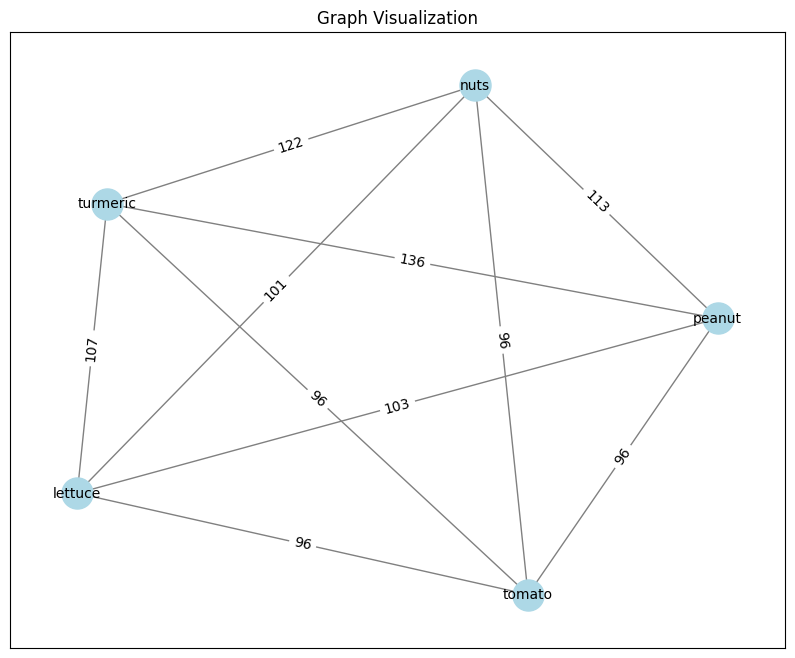

In [463]:
def draw_graph(G):
    plt.figure(figsize=(10, 8))  # グラフのサイズを指定
    pos = nx.spring_layout(G)  # ノードの配置を設定（spring_layout は一般的に使われるレイアウト）
    
    # ノードを描画
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')

    # エッジを描画
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='gray')

    # ノードのラベルを描画
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color='black')

    # エッジの重みを描画
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title('Graph Visualization')
    plt.show()

# グラフ G を描画
draw_graph(G)